## Feature selection, model development, revenue prediction

1. [Prepare data sets](#1.-Split-dataset-into-training,-test-and-validation-sets)
2. [Feature Selection](#2-feature-selection)
3. [Class imbalance](#3-class-imbalance)
4. [Propensity Models](#4-propensity-models)
   
      4.1. [Mutual Funds](#41-mutual-fund)

      4.2. [Credit Cards](#42-credit-cards)
      
      4.3. [Consumer Loan](#43-consumer-loan)
5. [Propensity Prediction on Test Set](#5-propensity-prediction-on-test-set)
6. [Revenue](#6-revenue)
7. [Results](#7-results)
8. [Summary](#summary)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) 

import seaborn as sns

from tensorflow import keras

from keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

2023-03-04 09:33:13.388084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dmo = pd.read_csv("../data/dmo_reduced.csv", sep = ';')
dmo.shape

(1506, 30)

In [3]:
dmo.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,0,51,7,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.0,0.0,0.000000,0.000000,-16.921429,23.0,250.000000,283.089286,247.607143,30.0,3.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
1,2,1,43,152,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.0,0.0,0.000000,0.000000,318.492857,3.0,307.142857,38.407143,35.714286,6.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,4,1,24,153,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.0,0.0,1110.381786,0.000000,-1776.360714,4.0,714.285714,526.037500,1963.165357,36.0,6.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,58,200,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.0,0.0,0.000000,0.000000,-1067.634643,14.0,157.142857,832.175000,1779.571429,41.0,4.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,6,0,24,19,1,0.0,0.0,0.0,0.0,1.0,4.297143,0.000000,0.0,0.0,0.000000,1982.071071,18.750714,2.0,357.142857,0.000000,0.000000,6.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Define features

In [4]:
soc_dem = ['Sex', 'Age', 'Tenure']

products_act_bal = ['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA','ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

inflow_outflow = ['flow_CA', 'TransactionsCred_CA', 'VolumeDebCash_Card', 
                  'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
                  'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder']

sales = ['Sale_MF', 'Sale_CC', 'Sale_CL']
revenue = ['Revenue_MF', 'Revenue_CC', 'Revenue_CL']

### 1. Split dataset into training, test and validation sets

In [5]:
dmo_train = dmo[~dmo['Sale_MF'].isna()]
dmo_test = dmo[dmo['Sale_MF'].isna()]

#### 1.1 Explore training data

In [6]:
dmo_train[soc_dem + products_act_bal + inflow_outflow + sales + revenue].describe()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,0.533702,45.358011,100.159116,1.078453,0.325967,0.898343,0.258564,0.111602,0.090608,2533.794455,3667.636088,3274.373238,38.460895,32.245206,315.892979,-15.221381,4.275138,268.016906,156.484730,737.899236,13.598895,1.973481,4.601105,0.201105,0.255249,0.285083,1.972902,2.854124,3.393204
std,0.503552,16.792988,65.223230,0.331646,0.582602,3.918789,0.438087,0.315051,0.320001,6404.119380,17565.864742,25476.494456,180.005275,157.737539,1524.262636,2750.073086,4.984322,890.831174,337.215152,3172.972062,12.998272,2.684222,5.238873,0.401048,0.436242,0.451704,10.207132,18.291659,7.590542
min,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000,-35604.112857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,31.000000,43.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.548571,0.000000,0.000000,0.000000,0.000000,0.000000,-105.532143,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,43.000000,95.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,542.171429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,75.000000,26.000000,178.571429,10.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,59.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2279.742857,0.481071,0.000000,0.000000,0.000000,0.000000,126.496786,4.000000,353.571429,180.327143,499.964286,19.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.214286,4.214286
max,1.000000,90.000000,271.000000,4.000000,3.000000,79.000000,1.000000,1.000000,2.000000,74934.956071,389883.830714,579084.107857,2055.325357,1767.785357,17300.489643,53935.488929,48.000000,23571.428571,3637.616786,61955.103929,83.000000,25.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


The features have different scales. This can provide bias into models and affects their performance. To deal with the issue, the features which deviate the most will be normalised.

In [7]:
features_to_normalize = ['flow_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
                         'VolumeDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA',
                         'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

min_max_scaler = preprocessing.MinMaxScaler()
dmo_train_norm = min_max_scaler.fit_transform(dmo_train[features_to_normalize])
dmo_train_norm = pd.DataFrame(dmo_train_norm, columns=features_to_normalize, 
                              index=dmo_train[features_to_normalize].index)
dmo_train_norm.head()

,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,0.397446,0.010606,0.077823,0.003997,0.017799,0.000000,0.0,0.000000,0.00868,0.000000
1,0.401192,0.013030,0.010558,0.000576,0.001478,0.034180,0.0,0.000000,0.00868,0.000000
4,0.397845,0.015152,0.000000,0.000000,0.000057,0.000000,0.0,0.000000,0.00868,0.114567
6,0.397675,0.010758,0.001919,0.000000,0.000000,0.000000,0.0,0.159084,0.00868,0.000000
11,0.396935,0.014394,0.047677,0.005045,0.004722,0.000015,0.0,0.000000,0.00868,0.199896


In [8]:
dmo_train_norm = pd.concat((dmo_train.drop(columns = features_to_normalize),
                           dmo_train_norm), 
                           axis = 1)

dmo_train_norm.describe()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,811.345856,0.533702,45.358011,100.159116,1.078453,0.325967,0.898343,0.258564,0.111602,0.090608,4.275138,13.598895,1.973481,4.601105,0.201105,0.255249,0.285083,1.972902,2.854124,3.393204,0.397465,0.011370,0.043018,0.011910,0.033813,0.009407,0.005654,0.018713,0.026762,0.018259
std,465.017036,0.503552,16.792988,65.223230,0.331646,0.582602,3.918789,0.438087,0.315051,0.320001,4.984322,12.998272,2.684222,5.238873,0.401048,0.436242,0.451704,10.207132,18.291659,7.590542,0.030713,0.037793,0.092702,0.051214,0.085462,0.045054,0.043994,0.087580,0.088454,0.088105
min,1.000000,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,417.000000,0.000000,31.000000,43.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.396457,0.000000,0.000000,0.000000,0.000941,0.000000,0.000000,0.000000,0.008680,0.000000
50%,819.000000,1.000000,43.000000,95.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397635,0.003182,0.007148,0.002882,0.007235,0.000000,0.000000,0.000000,0.008680,0.000000
75%,1214.000000,1.000000,59.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,4.000000,19.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.214286,4.214286,0.399048,0.015000,0.049573,0.008070,0.030423,0.000001,0.000000,0.000000,0.008680,0.000000
max,1613.000000,1.000000,90.000000,271.000000,4.000000,3.000000,79.000000,1.000000,1.000000,2.000000,48.000000,83.000000,25.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
dmo_train_norm.shape

(905, 30)

### 2. Feature Selection

First, the essential features of each model should be selected. For these purposes, Random Forests were used. Random Forests were chosen because they can describe nonlinear relationships while retaining evidence of partial dependency. Penalised generalised linear models, such as LASSO regression, might capture the partial dependence, i.e. possibly skewed estimated coefficients, yet they can only represent linear relations. On the other hand, SVM can model nonlinear associations but cannot detect partial dependency.

In [10]:
np.random.seed(42)

In [12]:
all_features = soc_dem + products_act_bal + inflow_outflow

rfmf = RandomForestClassifier(n_estimators = 500, random_state = 50)
rfcc = RandomForestClassifier(n_estimators = 500, random_state = 50)
rfcl = RandomForestClassifier(n_estimators = 500, random_state = 50)

rfmf.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_MF"]].to_numpy().ravel())
rfcc.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CC"]].to_numpy().ravel())
rfcl.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CL"]].to_numpy().ravel())

mf_feature_importances = rfmf.feature_importances_
cc_feature_importances = rfcc.feature_importances_
cl_feature_importances = rfcl.feature_importances_

mf_indices = np.argsort(mf_feature_importances)
cc_indices = np.argsort(cc_feature_importances)
cl_indices = np.argsort(cl_feature_importances)

#### Feature importances for MF

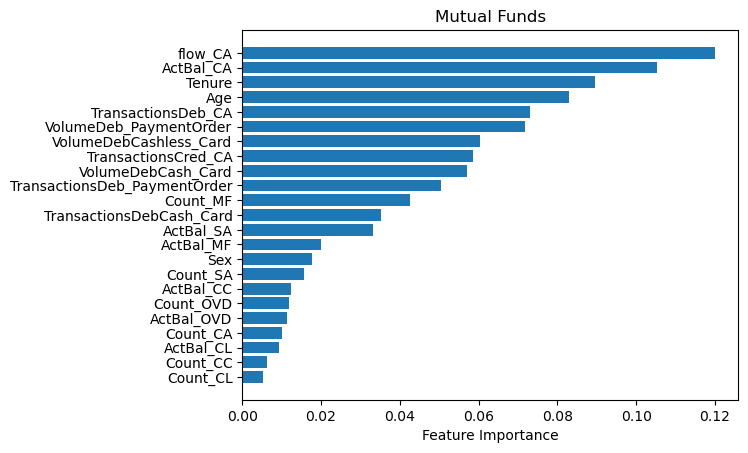

In [13]:
plt.title('Mutual Funds')
plt.barh(range(len(mf_indices)), mf_feature_importances[mf_indices], align = 'center')
plt.yticks(range(len(mf_indices)), [all_features[i] for i in mf_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of MF features according to RF with 5-fold Cross-Validation

In [14]:
rfe_mf = RFECV(rfmf, cv = 5, scoring = "neg_mean_squared_error")
rfe_mf.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_MF"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [15]:
mf_selected_features = np.array(all_features)[rfe_mf.get_support()]
mf_selected_features

array(['Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'flow_CA',
       'TransactionsCred_CA', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDeb_CA', 'TransactionsDeb_PaymentOrder'], dtype='<U28')

#### Feature importances for CC

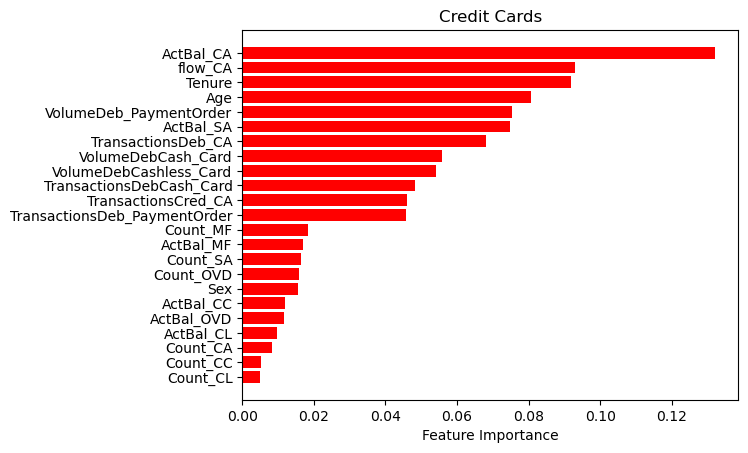

In [16]:
plt.title('Credit Cards')
plt.barh(range(len(cc_indices)), cc_feature_importances[cc_indices], color = "red", align = 'center')
plt.yticks(range(len(cc_indices)), [all_features[i] for i in cc_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of CC features according to RF with 5-fold Cross-Validation

In [17]:
rfe_cc = RFECV(rfcc, cv = 5, scoring = "neg_mean_squared_error")
rfe_cc.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CC"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [18]:
cc_selected_features = np.array(all_features)[rfe_cc.get_support()]
cc_selected_features

array(['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD',
       'ActBal_CC', 'ActBal_CL', 'flow_CA', 'TransactionsCred_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder'],
      dtype='<U28')

#### Feature importances for CL

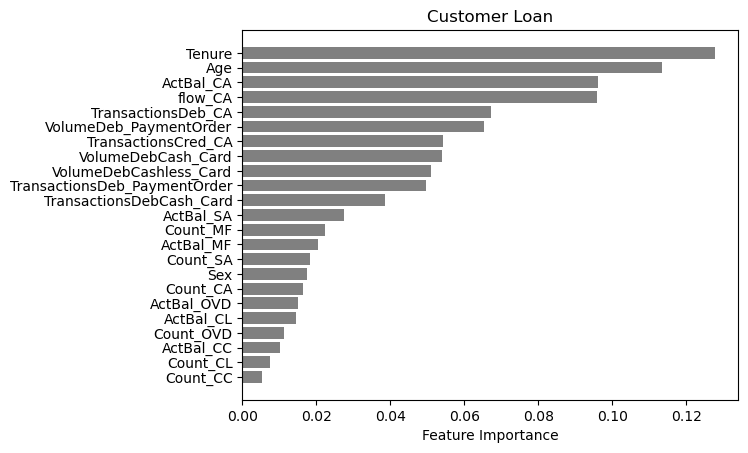

In [36]:
plt.title('Customer Loan')
plt.barh(range(len(cl_indices)), cl_feature_importances[cl_indices], color = "grey", align = 'center')
plt.yticks(range(len(cl_indices)), [all_features[i] for i in cl_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of CL features according to RF with 5-fold Cross-Validation

In [19]:
rfe_cl = RFECV(rfcl, cv = 5, scoring = "neg_mean_squared_error")
rfe_cl.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CL"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [20]:
cl_selected_features = np.array(all_features)[rfe_cl.get_support()]
cl_selected_features

array(['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'flow_CA',
       'TransactionsCred_CA', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDeb_CA', 'TransactionsDebCash_Card',
       'TransactionsDeb_PaymentOrder'], dtype='<U28')

The RF feature selection procedure results in different features selected for predicting each target sale variable.

#### Training datasets for three propensity models

In [21]:
dmo_train_mf = dmo_train_norm[['Sale_MF'] + list(mf_selected_features)]
dmo_train_cc = dmo_train_norm[['Sale_CC'] + list(cc_selected_features)]
dmo_train_cl = dmo_train_norm[['Sale_CL'] + list(cl_selected_features)]

In [22]:
dmo_train_mf.head()

,Sale_MF,Age,Tenure,Count_MF,ActBal_CA,ActBal_SA,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDeb_PaymentOrder
0,1.0,51,7,0.0,0.017799,0.000000,0.397446,23.0,0.010606,0.077823,0.003997,30.0,9.0
1,0.0,43,152,0.0,0.001478,0.034180,0.401192,3.0,0.013030,0.010558,0.000576,6.0,1.0
4,0.0,24,19,0.0,0.000057,0.000000,0.397845,2.0,0.015152,0.000000,0.000000,6.0,0.0
6,0.0,64,30,0.0,0.000000,0.000000,0.397675,21.0,0.010758,0.001919,0.000000,24.0,0.0
11,0.0,66,132,0.0,0.004722,0.000015,0.396935,3.0,0.014394,0.047677,0.005045,39.0,10.0


### 3. Class imbalance

#### Check if the data is balanced

In [23]:
dmo_train_mf.Sale_MF.value_counts()

0.0    723
1.0    182
Name: Sale_MF, dtype: int64

In [24]:
dmo_train_cc.Sale_CC.value_counts()

0.0    674
1.0    231
Name: Sale_CC, dtype: int64

In [25]:
dmo_train_cl.Sale_CL.value_counts()

0.0    647
1.0    258
Name: Sale_CL, dtype: int64

The data are highly imbalanced: there are more clients who did not buy products compared to those who did. Downsampling is used to deal with the problem.

#### Downsampling

In [29]:
# Subset the client who buy the products
dmo_train_mf_sale_yes = dmo_train_mf.loc[dmo_train_mf['Sale_MF'] == 1]
dmo_train_cc_sale_yes = dmo_train_cc.loc[dmo_train_cc['Sale_CC'] == 1]
dmo_train_cl_sale_yes = dmo_train_cl.loc[dmo_train_cl['Sale_CL'] == 1]

# Sample the clients who did not buy any product (the size is equal to ds with the clients with sales)
dmo_train_mf_sale_no = dmo_train_mf.loc[dmo_train_mf['Sale_MF'] == 0].sample(len(dmo_train_mf_sale_yes),
                                                                             random_state = 10)
dmo_train_cc_sale_no = dmo_train_cc.loc[dmo_train_cc['Sale_CC'] == 0].sample(len(dmo_train_cc_sale_yes),
                                                                            random_state = 10)
dmo_train_cl_sale_no = dmo_train_cl.loc[dmo_train_cl['Sale_CL'] == 0].sample(len(dmo_train_cl_sale_yes),
                                                                             random_state = 10)

# Concatenate the dataframes

dmo_train_mf = pd.concat([dmo_train_mf_sale_yes, dmo_train_mf_sale_no])
dmo_train_cc = pd.concat([dmo_train_cc_sale_yes, dmo_train_cc_sale_no])
dmo_train_cl = pd.concat([dmo_train_cl_sale_yes, dmo_train_cl_sale_no])

#### Results after downsampling

In [30]:
dmo_train_mf.Sale_MF.value_counts()

1.0    182
0.0    182
Name: Sale_MF, dtype: int64

In [31]:
dmo_train_cc.Sale_CC.value_counts()

1.0    231
0.0    231
Name: Sale_CC, dtype: int64

In [32]:
dmo_train_cl.Sale_CL.value_counts()

1.0    258
0.0    258
Name: Sale_CL, dtype: int64

#### Stratify to ensure same distribution of both classes in training and validation

##### Split training datasets for training and validation - Full dataset (no downsampling)

In [33]:
X_mf_f, X_cc_f, X_cl_f = dmo_train_norm[mf_selected_features], dmo_train_norm[cc_selected_features], dmo_train_norm[cl_selected_features]
Y_mf_f, Y_cc_f, Y_cl_f = dmo_train_norm['Sale_MF'], dmo_train_norm['Sale_CC'], dmo_train_norm['Sale_CL']

X_trainmf_f, X_valmf_f, Y_trainmf_f, Y_valmf_f = train_test_split(X_mf_f, Y_mf_f, test_size = 0.2, 
                                                                  random_state = 20, stratify = Y_mf_f)
X_traincc_f, X_valcc_f, Y_traincc_f, Y_valcc_f = train_test_split(X_cc_f, Y_cc_f, test_size = 0.2, 
                                                                  random_state = 20, stratify = Y_cc_f)
X_traincl_f, X_valcl_f, Y_traincl_f, Y_valcl_f = train_test_split(X_cl_f, Y_cl_f, test_size = 0.2, 
                                                                  random_state = 20, stratify=Y_cl_f)

##### Split training datasets for training and validation - Downsampled dataset

In [34]:
X_mf, X_cc, X_cl = dmo_train_mf[mf_selected_features], dmo_train_cc[cc_selected_features], dmo_train_cl[cl_selected_features]
Y_mf, Y_cc, Y_cl = dmo_train_mf['Sale_MF'], dmo_train_cc['Sale_CC'], dmo_train_cl['Sale_CL']

X_trainmf, X_valmf, Y_trainmf, Y_valmf = train_test_split(X_mf, Y_mf, test_size=0.2, random_state = 20, stratify=Y_mf)
X_traincc, X_valcc, Y_traincc, Y_valcc = train_test_split(X_cc, Y_cc, test_size=0.2, random_state = 20, stratify=Y_cc)
X_traincl, X_valcl, Y_traincl, Y_valcl = train_test_split(X_cl, Y_cl, test_size=0.2, random_state = 20, stratify=Y_cl)

### 4. Propensity Models

There is a classification problem: buyer vs non-buyer.

The propensity scores are most often estimated by logistic regression. However, the Neural networks, NN, have been noted as promising for propensity score estimation because they algorithmically handle nonlinear relationships and interactions. Therefore, we will compare two apporaches: the logistic regression and the NN with one hidden layer, adam optimizer and binary cross-entropy loss function.
For NN, using a sigmoid function, the probability will be predicted in the output layer. Root Mean Squared Error, RMSE, will be used to judge the model performance on training and validation tests.

The models will be applied to the imbalanced and downsampled data sets.

The Area under the ROC Curve, AUC, will be used to assess if the prediction is good.

In [35]:
np.random.seed(42)

#### Functions for NN model

In [36]:
def create_nn(X_data, nodes1, nodes2):
    # Input layer
    inputs = keras.layers.Input(shape=(X_data.shape[1],), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(nodes1, 'relu')(inputs)
    # layers_dense = keras.layers.Dense(nodes2, 'relu')(layers_dense)

    # Output layer
    outputs = keras.layers.Dense(1, 'sigmoid')(layers_dense)

    return keras.Model(inputs=inputs, outputs=outputs, name="nn_model")

In [74]:
def train_validate_nn_model(X_train, Y_train, X_val, Y_val, nodes1 = 5, nodes2 = 10):
    
    model = create_nn(X_train, nodes1, nodes2)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.RootMeanSquaredError()])
    early_stopping_monitor = EarlyStopping(patience=50)
    history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=500,
                    validation_data=(X_val, Y_val),
                    verbose=False,
                    callbacks=[early_stopping_monitor])
    history_df = pd.DataFrame.from_dict(history.history)
    
    sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
    plt.xlabel("epochs")
    plt.ylabel("RMSE")
    
    return model

#### 4.1. Mutual Fund

#### a. Logistic regression

In [38]:
# Training and validation - Full dataset

log_reg_mf_f = make_pipeline(StandardScaler(), LogisticRegression())
log_reg_mf_f.fit(X_trainmf_f, Y_trainmf_f)
roc_auc_score(Y_valmf_f, log_reg_mf_f.predict(X_valmf_f))

0.5416666666666666

In [39]:
# Training and validation - Balanced dataset

log_reg_mf = make_pipeline(StandardScaler(), LogisticRegression())
log_reg_mf.fit(X_trainmf, Y_trainmf)
roc_auc_score(Y_valmf, log_reg_mf_f.predict(X_valmf))

0.5540540540540541

#### b. Neural Networks

2023-03-04 09:44:25.301795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


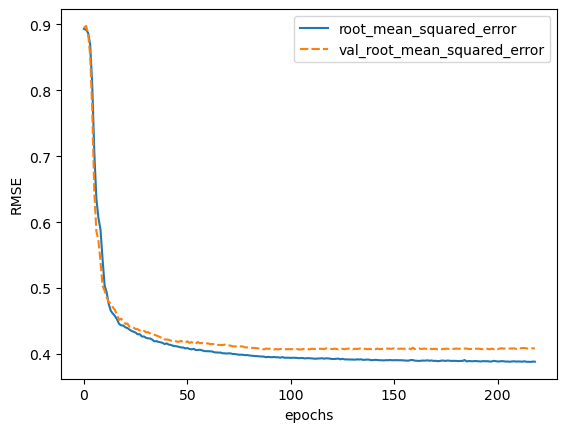

In [40]:
# Training and validation - Full dataset
sale_mf_f = train_validate_nn_model(X_trainmf_f, Y_trainmf_f, X_valmf_f, Y_valmf_f, 10)

In [41]:
# AUC Score - Full dataset
roc_auc_score(Y_valmf_f, sale_mf_f.predict(X_valmf_f))

6/6 [==============================] - 0s 1ms/step


0.4952107279693486

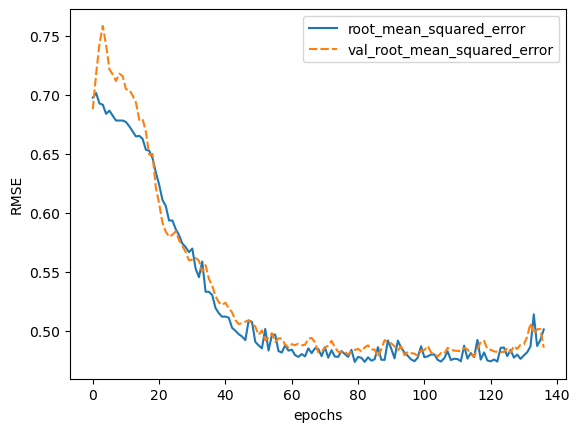

In [42]:
# Training and validation - Balanced dataset
sale_mf = train_validate_nn_model(X_trainmf, Y_trainmf, X_valmf, Y_valmf, 10)

In [43]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valmf, sale_mf.predict(X_valmf))

3/3 [==============================] - 0s 1ms/step


0.6261261261261262

The logistic regression prefromed almost the same on the downsampled as on full data sets (AUC ~ 0.55). The balanced dataset migt be too small to improve modelling performance. The results indicate that the models predictive ability is almost no better than random guessing.
In comparison, the NN model on balanced data gives a higher AUC of 0.63. Therefore, we will use NN and downsampled data for MF propensity modelling . 

#### 4.2. Credit Cards

#### a. Logistic regression

In [44]:
# Training and validation - Full dataset

log_reg_cc_f = make_pipeline(StandardScaler(), LogisticRegression())
log_reg_cc_f.fit(X_traincc_f, Y_traincc_f)
roc_auc_score(Y_valcc_f, log_reg_cc_f.predict(X_valcc_f))

0.5973429951690821

In [45]:
# Training and validation - Balanced dataset

log_reg_cc = make_pipeline(StandardScaler(), LogisticRegression())
log_reg_cc.fit(X_traincc, Y_traincc)
roc_auc_score(Y_valcc, log_reg_cc.predict(X_valcc))

0.5277520814061054

#### b. Neural Networks

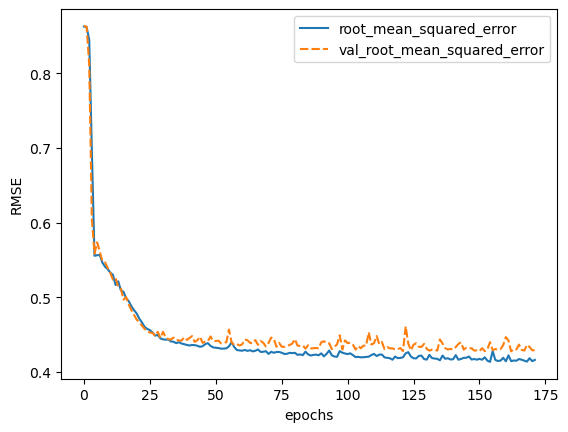

In [46]:
# Training and validation - Full dataset
sale_cc_f = train_validate_nn_model(X_traincc_f, Y_traincc_f, X_valcc_f, Y_valcc_f, 10)

In [47]:
# AUC Score - Full dataset
roc_auc_score(Y_valcc_f, sale_cc_f.predict(X_valcc_f))

6/6 [==============================] - 0s 963us/step


0.6441223832528181

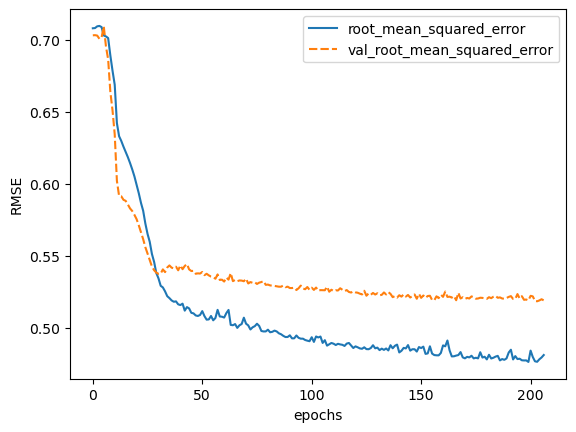

In [59]:
# Training and validation - Balanced dataset
sale_cc = train_validate_nn_model(X_traincc, Y_traincc, X_valcc, Y_valcc, 10)

In [60]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valcc, sale_cc.predict(X_valcc))

3/3 [==============================] - 0s 1ms/step


0.513413506012951

The CC propensity modelling performed on the full datasets gives smaller the MRSE and greater AUC score (both logistic regression and NN). The balanced dataset migt be too small to improve modelling performance. The NN will be further used because it resulted in a better prediction (AUC(nn) ~ 0.65 vs. AUC(lr) ~ 0.6).

#### 4.3. Consumer Loan

#### a. Logistic regression

In [61]:
# Training and validation - Full dataset

log_reg_cl_f = make_pipeline(StandardScaler(), LogisticRegression())
log_reg_cl_f.fit(X_traincl_f, Y_traincl_f)
roc_auc_score(Y_valcl_f, log_reg_cl_f.predict(X_valcl_f))

0.5210942158616577

In [62]:
# Training and validation - Balanced dataset

log_reg_cl = make_pipeline(StandardScaler(), LogisticRegression())
log_reg_cl.fit(X_traincl, Y_traincl)
roc_auc_score(Y_valcl, log_reg_cl.predict(X_valcl))

0.5961538461538461

#### b. Neural Networks

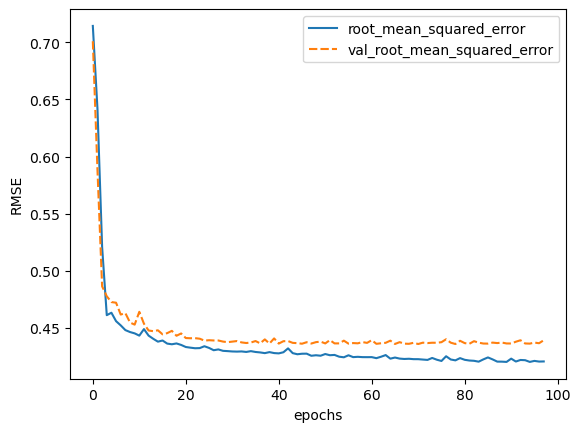

In [77]:
# Training and validation - Full dataset
sale_cl_f = train_validate_nn_model(X_traincl_f, Y_traincl_f, X_valcl_f, Y_valcl_f, 10)

In [78]:
# AUC Score - Full dataset
roc_auc_score(Y_valcl_f, sale_cl_f.predict(X_valcl_f))

6/6 [==============================] - 0s 989us/step


0.6529516994633273

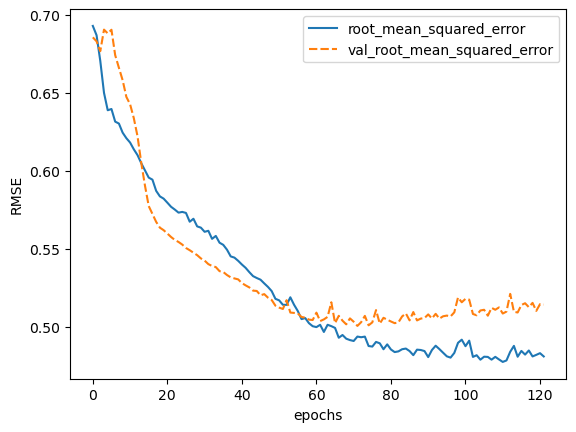

In [79]:
# Training and validation - Balanced dataset
sale_cl = train_validate_nn_model(X_traincl, Y_traincl, X_valcl, Y_valcl, 7)

In [80]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valcl, sale_cl.predict(X_valcl))

4/4 [==============================] - 0s 1ms/step


0.5528846153846154

The Consumer Loan (CL) propensity modelling using logistic regression performed on the balanced better than on full datasets: AUC of 0.6 vs AUC 0f 0.52. In case of NN, the results are opposite, i.e. the prediction is better based on full data: smaller MRSE, less difference between training and validation MRSE and higher AUC score. The balanced dataset migt be too small to improve modelling performance. The NN built on the full data set will be further used because it resulted in a better prediction (AUC(nn) ~ 0.65).

### 5. Propensity Prediction on Test Set

#### Test Data preparation

In [81]:
features_to_normalize = ['flow_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
                         'VolumeDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA',
                         'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

min_max_scaler = preprocessing.MinMaxScaler()
dmo_test_norm = min_max_scaler.fit_transform(dmo_test[features_to_normalize])
dmo_test_norm = pd.DataFrame(dmo_test_norm, columns=features_to_normalize, 
                              index=dmo_test[features_to_normalize].index)

dmo_test_norm = pd.concat((dmo_test.drop(columns = features_to_normalize),
                           dmo_test_norm), 
                           axis = 1)

dmo_test_norm.describe()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,0.0,0.0,0.0,0.0,0.0,0.0,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,799.351082,0.527454,45.038270,103.469218,1.088186,0.277870,0.672213,0.256240,0.093178,0.116473,4.129784,13.154742,1.983361,4.600666,NaN,NaN,NaN,NaN,NaN,NaN,0.395374,0.025241,0.055348,0.009884,0.013536,0.018293,0.005295,0.019345,0.013326,0.020300
std,469.013036,0.502986,16.851316,63.715588,0.356665,0.536339,2.101756,0.436919,0.290924,0.427876,4.918312,13.046367,2.747676,5.246929,NaN,NaN,NaN,NaN,NaN,NaN,0.038733,0.056871,0.112308,0.047763,0.048460,0.079392,0.050738,0.094061,0.068949,0.092447
min,4.000000,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,381.000000,0.000000,31.000000,48.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.391715,0.000000,0.000000,0.000000,0.000250,0.000000,0.000000,0.000000,0.000000,0.000000
50%,796.000000,1.000000,42.000000,102.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.393141,0.007353,0.003587,0.002362,0.002056,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1204.000000,1.000000,58.000000,152.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,19.000000,3.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.394667,0.034926,0.059654,0.007221,0.011210,0.000000,0.000000,0.000000,0.000000,0.000000
max,1614.000000,1.000000,97.000000,273.000000,4.000000,5.000000,28.000000,1.000000,1.000000,5.000000,37.000000,72.000000,17.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Prediction of the Sale_MF, Sale_CC and Sale_CL probabilities for the test set

In [82]:
dmo_test_norm.loc[:, 'Sale_MF'] = sale_mf.predict(dmo_test_norm[mf_selected_features])
dmo_test_norm.loc[:, 'Sale_CC'] = sale_cc_f.predict(dmo_test_norm[cc_selected_features])
dmo_test_norm.loc[:, 'Sale_CL'] = sale_cl_f.predict(dmo_test_norm[cl_selected_features])
dmo_test_norm

19/19 [==============================] - 0s 699us/step


,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
2,4,1,24,153,1,1.0,0.0,0.0,1.0,0.0,4.0,36.0,6.0,13.0,0.391406,0.269074,0.782087,NaN,NaN,NaN,0.367526,0.073529,0.212942,0.027161,9.324391e-03,0.000348,0.0,0.000000,0.315249,0.000000
3,5,0,58,200,1,1.0,0.0,0.0,0.0,0.0,14.0,41.0,4.0,13.0,0.564059,0.327782,0.257593,NaN,NaN,NaN,0.377746,0.016176,0.336867,0.024621,3.120184e-02,0.036832,0.0,0.000000,0.000000,0.000000
5,7,0,55,227,1,0.0,0.0,0.0,0.0,0.0,2.0,10.0,1.0,1.0,0.581598,0.262652,0.111046,NaN,NaN,NaN,0.397301,0.001838,0.027993,0.000148,5.127090e-03,0.000000,0.0,0.000000,0.000000,0.000000
7,9,0,33,182,1,0.0,0.0,1.0,0.0,0.0,4.0,7.0,1.0,3.0,0.563618,0.349573,0.426874,NaN,NaN,NaN,0.393200,0.005515,0.000000,0.002362,2.973416e-03,0.000000,0.0,0.000000,0.000000,0.000000
8,10,0,29,48,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.516993,0.348905,0.230612,NaN,NaN,NaN,0.393128,0.000000,0.000000,0.000000,1.477241e-03,0.000532,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,1606,1,47,78,1,0.0,0.0,0.0,0.0,1.0,5.0,17.0,0.0,5.0,0.523361,0.188692,0.115633,NaN,NaN,NaN,0.403891,0.000000,0.052348,0.003039,1.379318e-02,0.000000,0.0,0.000000,0.000000,0.013022
1500,1609,1,31,111,1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.500305,0.257546,0.178010,NaN,NaN,NaN,0.392883,0.000000,0.000000,0.001286,1.205718e-03,0.000000,0.0,0.000000,0.000000,0.000000
1501,1610,0,48,92,1,0.0,0.0,1.0,0.0,0.0,5.0,18.0,3.0,7.0,0.478839,0.302600,0.132976,NaN,NaN,NaN,0.488702,0.020221,0.017767,0.002343,1.145524e-03,0.000000,0.0,0.335006,0.000000,0.000000
1502,1611,0,41,181,1,0.0,0.0,1.0,0.0,0.0,3.0,11.0,1.0,6.0,0.466742,0.363376,0.263579,NaN,NaN,NaN,0.392063,0.018382,0.013012,0.012321,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000


### 6. Revenue

The goal is to investigate the potential revenue generated by a marketing campaign targeting clients with high propensity.

The mean of each revenue type (MF, CC, CL) is used as target revenue for a client buying the corresponding product type.

#### EDA for revenue data

<AxesSubplot:>

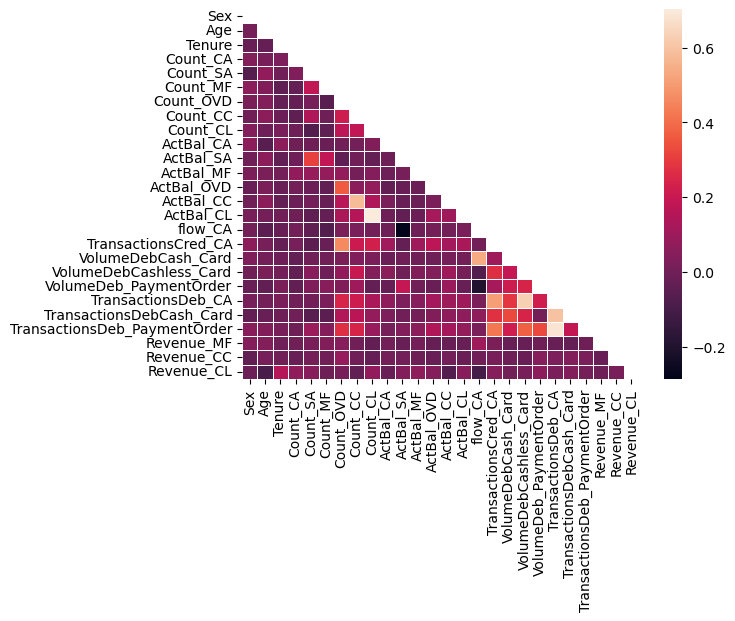

In [83]:
dmo_cor = dmo_train[soc_dem + products_act_bal + inflow_outflow + revenue].corr()

mask = np.triu(np.ones_like(dmo_cor))

sns.heatmap(dmo_cor, annot=False, linewidth=.5, mask=mask, xticklabels=True, yticklabels=True)

The revenue features don't correlate strongly with any other features.

#### Outlier detection

Remove Revenues with zeroes

In [84]:
revenue_mf = dmo_train['Revenue_MF'][dmo_train['Revenue_MF']>0]
revenue_cc = dmo_train['Revenue_CC'][dmo_train['Revenue_CC']>0]
revenue_cl = dmo_train['Revenue_CL'][dmo_train['Revenue_CL']>0]

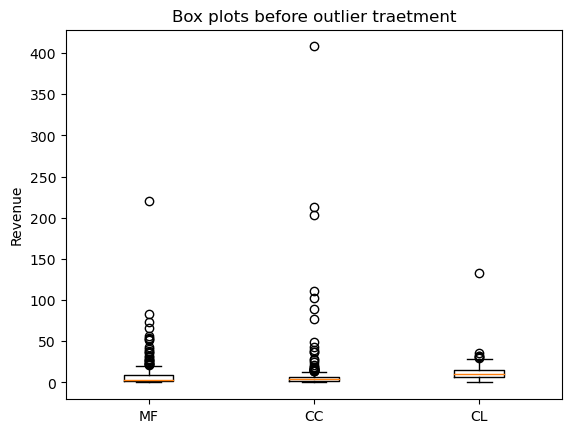

In [86]:
plt.boxplot([revenue_mf, revenue_cc, revenue_cl], labels = ["MF", "CC", "CL"])
plt.title("Box plots before outlier traetment")
plt.ylabel('Revenue')
plt.show()

#### Remove outlier

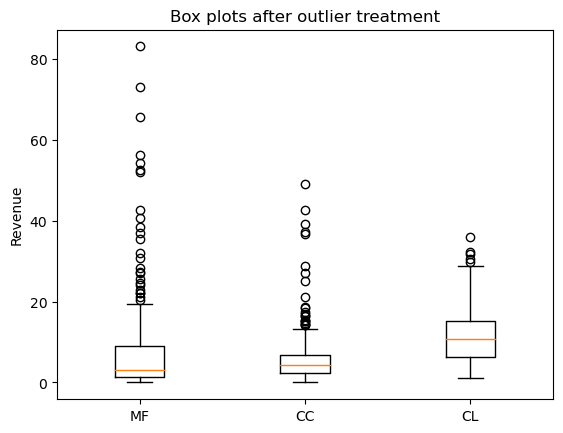

In [87]:
revenue_mf = revenue_mf[revenue_mf < 100]
revenue_cc = revenue_cc[revenue_cc < 50]
revenue_cl = revenue_cl[revenue_cl < 100]

plt.boxplot([revenue_mf, revenue_cc, revenue_cl], labels = ["MF", "CC", "CL"])
plt.title("Box plots after outlier treatment")
plt.ylabel('Revenue')
plt.show()

#### Revenue values for test data

In [88]:
[revenue_mf.mean(), revenue_cc.mean(), revenue_cl.mean()]

[8.646341752170482, 6.154907525510203, 11.430250138966093]

In [89]:
dmo_test_norm.loc[:, 'Revenue_MF'] = revenue_mf.mean()
dmo_test_norm.loc[:, 'Revenue_CC'] = revenue_cc.mean()
dmo_test_norm.loc[:, 'Revenue_CL'] = revenue_cl.mean()

final_features = ['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']

final_df = dmo_test_norm[final_features]
final_df


,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
2,4,0.391406,0.269074,0.782087,8.646342,6.154908,11.43025
3,5,0.564059,0.327782,0.257593,8.646342,6.154908,11.43025
5,7,0.581598,0.262652,0.111046,8.646342,6.154908,11.43025
7,9,0.563618,0.349573,0.426874,8.646342,6.154908,11.43025
8,10,0.516993,0.348905,0.230612,8.646342,6.154908,11.43025
...,...,...,...,...,...,...,...
1497,1606,0.523361,0.188692,0.115633,8.646342,6.154908,11.43025
1500,1609,0.500305,0.257546,0.178010,8.646342,6.154908,11.43025
1501,1610,0.478839,0.302600,0.132976,8.646342,6.154908,11.43025
1502,1611,0.466742,0.363376,0.263579,8.646342,6.154908,11.43025


### 7. Results

#### 7.1. Which clients have higher propensity to buy consumer loan?

In [90]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_CL', ascending = False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_CL']].to_csv('../results/01_propensity_to_cl.csv', sep=';', header = True, index = False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
628,674,0.537013,0.193516,0.936890,8.646342,6.154908,11.43025
1042,1119,0.896161,0.094250,0.927773,8.646342,6.154908,11.43025
648,697,0.417880,0.323860,0.909672,8.646342,6.154908,11.43025
523,562,0.355024,0.257988,0.899280,8.646342,6.154908,11.43025
507,545,0.560164,0.398720,0.870624,8.646342,6.154908,11.43025


##### Important features for determining their propensity:

In [91]:
print(cl_selected_features)

['Age' 'Tenure' 'ActBal_CA' 'ActBal_SA' 'ActBal_MF' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA' 'TransactionsDebCash_Card'
 'TransactionsDeb_PaymentOrder']


#### 7.2. Which clients have higher propensity to buy credit card?

In [92]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_CC', ascending = False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_CC']].to_csv('../results/02_propensity_to_cc.csv', sep = ';', header = True, index = False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
141,150,0.037852,0.993792,0.005271,8.646342,6.154908,11.43025
1319,1414,0.319789,0.859948,0.102207,8.646342,6.154908,11.43025
708,760,0.448192,0.798127,0.133509,8.646342,6.154908,11.43025
329,352,0.551423,0.759026,0.365118,8.646342,6.154908,11.43025
496,532,0.396204,0.691219,0.118923,8.646342,6.154908,11.43025


##### Important features for determining their propensity:

In [93]:
print(cl_selected_features)

['Age' 'Tenure' 'ActBal_CA' 'ActBal_SA' 'ActBal_MF' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA' 'TransactionsDebCash_Card'
 'TransactionsDeb_PaymentOrder']


#### 7.3. Which clients have higher propensity to buy mutual fund?

In [94]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_MF', ascending = False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_MF']].to_csv('../results/03_propensity_to_mf.csv', sep = ';', header = True, index = False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
365,389,0.997387,0.367054,0.137633,8.646342,6.154908,11.43025
200,211,0.956005,0.332458,0.169458,8.646342,6.154908,11.43025
489,524,0.936528,0.180015,0.474958,8.646342,6.154908,11.43025
226,239,0.930313,0.246159,0.452093,8.646342,6.154908,11.43025
543,583,0.909755,0.242427,0.728681,8.646342,6.154908,11.43025


##### Important features for determining their propensity:

In [95]:
print(mf_selected_features)

['Age' 'Tenure' 'Count_MF' 'ActBal_CA' 'ActBal_SA' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA'
 'TransactionsDeb_PaymentOrder']


#### 7.4. Which clients are to be targeted with which offer?

The hypothesis is that higher revenue is generated from the clients with the higher propensity.

Expected revenue for each client per product is calculated by multiplying the propensity and mean revenue. The highest expected revenue among the three products is chosen as the best offer for each client. The top 100 customers with the highest revenue should be targeted.

In [96]:
final_df.loc[:, 'Score_MF'] = final_df.loc[:, 'Sale_MF'] * final_df.loc[:, 'Revenue_MF']
final_df.loc[:, 'Score_CC'] = final_df.loc[:, 'Sale_CC'] * final_df.loc[:, 'Revenue_CC']
final_df.loc[:, 'Score_CL'] = final_df.loc[:, 'Sale_CL'] * final_df.loc[:, 'Revenue_CL']

final_df

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL
365,389,0.997387,0.367054,0.137633,8.646342,6.154908,11.43025,8.623747,2.259182,1.573184
200,211,0.956005,0.332458,0.169458,8.646342,6.154908,11.43025,8.265943,2.046246,1.936950
489,524,0.936528,0.180015,0.474958,8.646342,6.154908,11.43025,8.097543,1.107974,5.428883
226,239,0.930313,0.246159,0.452093,8.646342,6.154908,11.43025,8.043803,1.515085,5.167535
543,583,0.909755,0.242427,0.728681,8.646342,6.154908,11.43025,7.866055,1.492115,8.329011
...,...,...,...,...,...,...,...,...,...,...
666,715,0.193110,0.378621,0.166464,8.646342,6.154908,11.43025,1.669692,2.330377,1.902724
1337,1433,0.173197,0.207713,0.095978,8.646342,6.154908,11.43025,1.497521,1.278453,1.097052
740,796,0.147825,0.247082,0.142427,8.646342,6.154908,11.43025,1.278143,1.520764,1.627975
928,996,0.141190,0.220764,0.266700,8.646342,6.154908,11.43025,1.220778,1.358783,3.048447


In [97]:
def compare(client):
    if client['Score_MF'] > client['Score_CC'] and client['Score_MF'] > client['Score_CL']:   # MF
        result = [client['Score_MF'], 'Mutual Fund']
    elif client['Score_CC'] > client['Score_MF'] and client['Score_CC'] > client['Score_CL']: # CC
        result = [client['Score_CC'], 'Credit Card']
    elif client['Score_CL'] > client['Score_MF'] and client['Score_CL'] > client['Score_CC']: # CL
        result = [client['Score_CL'], 'Consumer Loan']
    return result

final_df.loc[:, 'Expected_Revenue'] = final_df.apply(lambda client:compare(client)[0], axis = 1)
final_df.loc[:, 'Best_Offer'] = final_df.apply(lambda client:compare(client)[1], axis = 1)
final_df

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL,Expected_Revenue,Best_Offer
365,389,0.997387,0.367054,0.137633,8.646342,6.154908,11.43025,8.623747,2.259182,1.573184,8.623747,Mutual Fund
200,211,0.956005,0.332458,0.169458,8.646342,6.154908,11.43025,8.265943,2.046246,1.936950,8.265943,Mutual Fund
489,524,0.936528,0.180015,0.474958,8.646342,6.154908,11.43025,8.097543,1.107974,5.428883,8.097543,Mutual Fund
226,239,0.930313,0.246159,0.452093,8.646342,6.154908,11.43025,8.043803,1.515085,5.167535,8.043803,Mutual Fund
543,583,0.909755,0.242427,0.728681,8.646342,6.154908,11.43025,7.866055,1.492115,8.329011,8.329011,Consumer Loan
...,...,...,...,...,...,...,...,...,...,...,...,...
666,715,0.193110,0.378621,0.166464,8.646342,6.154908,11.43025,1.669692,2.330377,1.902724,2.330377,Credit Card
1337,1433,0.173197,0.207713,0.095978,8.646342,6.154908,11.43025,1.497521,1.278453,1.097052,1.497521,Mutual Fund
740,796,0.147825,0.247082,0.142427,8.646342,6.154908,11.43025,1.278143,1.520764,1.627975,1.627975,Consumer Loan
928,996,0.141190,0.220764,0.266700,8.646342,6.154908,11.43025,1.220778,1.358783,3.048447,3.048447,Consumer Loan


In [98]:
final_df = final_df.sort_values('Expected_Revenue', ascending=False)
target_clients = final_df.loc[:,['Client', 'Expected_Revenue', 'Best_Offer']].head(100)
target_clients['Best_Offer'].value_counts()

Mutual Fund      51
Consumer Loan    48
Credit Card       1
Name: Best_Offer, dtype: int64

**51** clients should be targeted with **Mutual Fund** offer

**48** clients should be targeted with **Consumer Loan** offer

**1** client should be targeted with **Credit Card** offer

In [99]:
# Save output to csv file
target_clients.to_csv('../results/04_target_clients.csv', sep=';', header=True, index=False)
target_clients

,Client,Expected_Revenue,Best_Offer
628,674,10.708890,Consumer Loan
1042,1119,10.604683,Consumer Loan
648,697,10.397784,Consumer Loan
523,562,10.278992,Consumer Loan
507,545,9.951450,Consumer Loan
...,...,...,...
778,834,6.236462,Mutual Fund
1339,1435,6.217126,Mutual Fund
1449,1550,6.172060,Mutual Fund
661,710,6.149744,Mutual Fund


#### 7.5. What would be the expected revenue?

In [100]:
target_clients['Expected_Revenue'].sum()

749.5677863246713

### Summary

The goal of the task was to maximise revenue from direct marketing campaigns with a limited number of clients to target with a specific product per client. The input data included social-demographical data, products and actual account volumes, inflow/outflow on C/A turnovers, and actual sales and revenues for 60% of clients.

First, the input data were combined into a single dataset (see 01_transform_ds.ipynb). The combined dataset dmo.csv is stored in the folder data. Then exploratory data analysis, EDA, was applied to the generated dataset (see 02_exploratory_data_analysis.ipynb). During EDA, imputation for missing values, feature reduction or transformation based on correlations and normalization were applied as a pre-processing step. The reduced dataset dmo_reduced.csv is stored in the folder data.

Then, the most important features of each model were selected. For these purposes, Random Forests, RF, were used. RF was chosen because it can describe nonlinear relationships while retaining evidence of partial dependency. Penalised generalised linear models, such as LASSO regression, might capture the partial dependency, i.e. possibly skewed estimated coefficients, yet they can only represent linear relations. SVM can model nonlinear associations but cannot detect partial dependency. The best sets of Mutual Fund (MF), Credit Card (CC) and Consumer Loan (CL) features were selected according to RF with 5-fold Cross-Validation. This procedure results in different features selected for predicting each target sale variable. For the sets of features, see sections 7.1 - 7.3.

The data was highly imbalanced: more clients didn't buy products compared to those who did. Downsampling was used to deal with the problem.

Although the propensity scores are most often estimated by logistic regression, the Neural networks, NN, have been noted as promising for propensity score estimation because they algorithmically handle nonlinear relationships and interactions. Here, both logistic regression and keras NN with one hidden layer, adam optimizer and binary cross-entropy loss function was used to build MF, CC, CL propensity models. For NN, a sigmoid function was used and the probability was predicted as an output layer. Root Mean Squared Error, RMSE, was used as a metric which judged the model performance on training and validation tests. The models were applied to the imbalanced and downsampled data sets using the ML, CC, CL sets of important features. The Area under the ROC Curve, AUC, was used to assess if the prediction was good. Overall, the NN performed better for each type of product. The performance of ML ropensity models on the balanced data was better comparing to the preformance on the full data: lower MRSE and higher AUC scores. In contrast, the CC and CL models on balanced data returned worse prediction than on the full data. This can be explained by the fact that the balanced datasets might have been too small to improve modelling performance. Across all models, the validation MRSE was **~40** and AUC scores were between **50** and **65**.

The sales propensity for the test data was predicted using the generated NN models. After removing outliers, i.e. those clients who tended to deviate from the majority, the average revenue for each sale type from training data was then considered in the test data as the target revenue. The expected revenue for each client per product was calculated by multiplying the propensity and mean revenue. The highest expected revenue among the three products was considered the best offer for each client to maximise the total revenue. The top 100 customers with the highest revenue should have been targeted. These top 100 clients were obtained by ranking on maximum expected revenue per client. The expected revenue with this strategy is **749.57**. The list of the top 100 clients which should be contacted (**51** with mutual funds, **48** with cunsomer loan and **1** with credit card) is stored in the *results* folder: 04_target_clients.csv. The results folder also contains the following data:

- *01_propensity_to_cl.csv*: the list of clients who have a higher propensity to buy consumer loan
- *02_propensity_to_cc.csv*: the list of clients who have a higher propensity to buy credit card
- *03_propensity_to_mf.csv*: the list of clients who have a higher propensity to buy a mutual fund